# Study the effect of K on low-level MILP

In [13]:
import sys
sys.path.append('../../')
import numpy as np
from panav.environment.env import MultiTunnelEnv
from panav.SAMP.solvers import Tube_Planning
from panav.viz import draw_env
import pickle as pkl


from time import time
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [202]:
N = 2
limits = [(-20,20),(-20,20)]
n_tunnel = 1
bloating_r = 0.5
vmax = 1.0
w = 2.5* bloating_r
env = MultiTunnelEnv(n_tunnel = n_tunnel, 
                    tunnel_width = w,
                    limits=limits, 
                    N_agent = N)



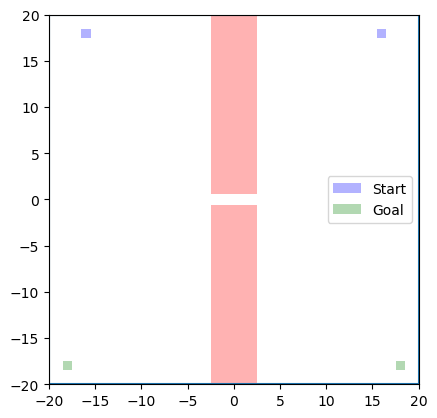

In [203]:
draw_env(env)

In [204]:
from panav.util import count_interger_var
class Vanilla_Tube_Planning(Tube_Planning):
    def __init__(self, env, start, goal, vmax=1, bloating_r=0.5, d=2, t0=0, K_max=10, T_end_constraints=None, ignore_finished_agents=False, goal_reach_eps=None) -> None:
        super().__init__(env, start, goal, vmax, bloating_r, d, t0, K_max, T_end_constraints, ignore_finished_agents, goal_reach_eps)
        self.K =  self.K_max

    def plan(self,obstacle_trajectories=[],lazy=False):
        return self.plan_core(obstacle_trajectories)
    
    def count_int_constraints(self,obstacle_trajectories=[]):
        _,_,_,prob = self.plan_core(obstacle_trajectories,solve_inplace = False)
        return count_interger_var(prob)

In [209]:
from panav.sequential import sequential_planning
Ks = np.arange(3,13)
runtimes = []
plans = []
num_int_constraints = []

from functools import partial

planner = Vanilla_Tube_Planning
for K in Ks:
    solver = partial(Vanilla_Tube_Planning,K_max = K)
    p,rt,ni = sequential_planning(solver,env,vmax,bloating_r,
                                  TIMEOUT=1000,
                                  return_runtimes=True,return_int_constrains=True)
    runtimes.append(rt)
    plans.append(p)
    num_int_constraints.append(ni)
    print(K,ni)


Planning for agent 0/2
Planning for agent 1/2
3 [24, 147]
Planning for agent 0/2
Planning for agent 1/2
4 [32, 244]
Planning for agent 0/2
Planning for agent 1/2
5 [40, 365]
Planning for agent 0/2
Planning for agent 1/2
6 [48, 510]
Planning for agent 0/2
Planning for agent 1/2
7 [56, 679]
Planning for agent 0/2
Planning for agent 1/2
8 [64, 872]
Planning for agent 0/2
Planning for agent 1/2
9 [72, 1089]
Planning for agent 0/2
Planning for agent 1/2
10 [80, 1330]
Planning for agent 0/2
Planning for agent 1/2
11 [88, 1595]
Planning for agent 0/2
Planning for agent 1/2
12 [96, 1884]


In [212]:
with open('./data/KEffect.pkl','wb') as fp:
    pkl.dump(dict(runtimes=runtimes,num_int_constraints=num_int_constraints,plans=plans),fp)

/var/folders/4v/bq7m33xj6b9fm2jfm0ngdg3c0000gn/T/ipykernel_52423/3653075189.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plans=np.array(results['plans'])


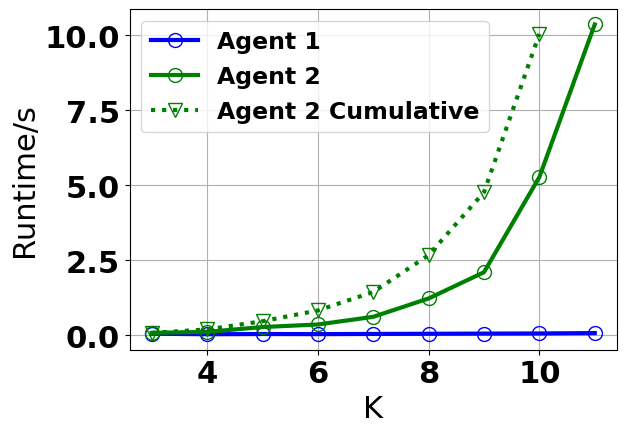

In [258]:
from matplotlib import pyplot as plt
from matplotlib import rc 
font = {'size'   : 22,'weight':'bold'}
rc('font', **font)
with open('./data/KEffect.pkl','rb') as fp:
    results=pkl.load(fp)
    runtimes=np.array(results['runtimes'])
    num_int_constraints=np.array(results['num_int_constraints'])
    plans=np.array(results['plans'])

idx_to_plot = np.arange(len(Ks)-1)

color = ['blue','green']
for n in range(N):
    RT = [rt[n] for rt in runtimes[idx_to_plot]]
    plt.plot(Ks[idx_to_plot],RT,
             marker = 'o',lw=3,markersize=10,markerfacecolor='none',label = f'Agent {n+1}',color=color[n])
    if n>0:
        plt.plot(Ks[idx_to_plot][:-1],np.cumsum(RT)[:-1],
                marker = 'v',lw=3,ls='dotted',markersize=10,markerfacecolor='none',label = f'Agent {n+1} Cumulative',color=color[n])

plt.grid('on')
plt.xlabel("K")
plt.ylabel("Runtime/s")
plt.legend(prop = dict(size = 17))
plt.tight_layout()
plt.savefig('./simFigures/KEffect/runtime.pdf')

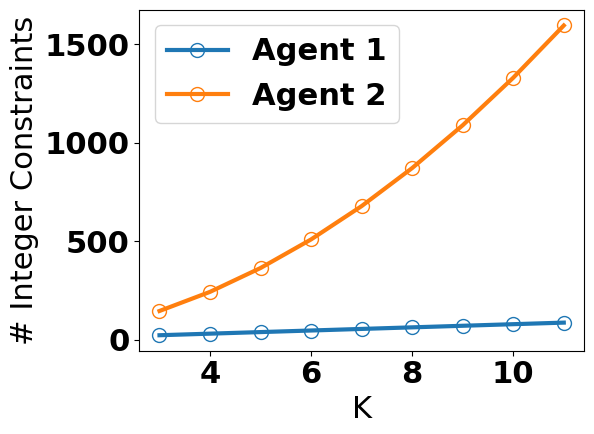

In [259]:

for n in range(N):
    plt.plot(Ks[idx_to_plot],[nums[n] for nums in num_int_constraints[idx_to_plot]],
             lw=3,markersize=10,marker = 'o',markerfacecolor='none',label = f'Agent {n+1}')
    
plt.xticks(np.arange(4,11,2),np.arange(4,11,2))
plt.xlabel("K")
plt.ylabel("# Integer Constraints")
plt.legend()

plt.tight_layout()
plt.savefig('./simFigures/KEffect/num_int_constraints.pdf')

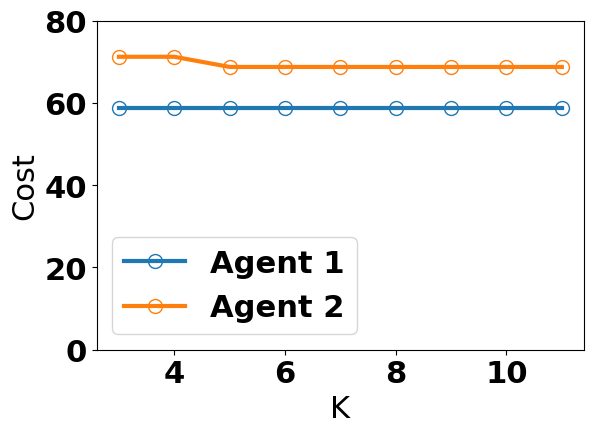

In [232]:
for n in range(N):
    plt.plot(Ks[idx_to_plot],[plan[n][0][-1] for plan in plans[idx_to_plot]],
             lw=3,markersize=10,marker = 'o',markerfacecolor='none',label = f'Agent {n+1}')
plt.xlabel("K")
plt.ylabel("Cost")
plt.ylim((0,80))
plt.legend()
plt.tight_layout()
plt.savefig('./simFigures/KEffect/cost.pdf')